In [73]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch

sc.settings.verbosity = 3


In [74]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [75]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


# Read Data

In [77]:
from skimage import exposure 

def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.5, 99.5))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)
    return img

In [78]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_flowjo.h5ad"
adata = sc.read_h5ad(adata_path)

C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [79]:
marker = 'COL1'
imgs_col = []

# Read COL1 images
for donor in donors:
    path = p_dir / "data" / "whole_stitched"/ donor / f"{marker}.tif"
    
    img = skimage.io.imread(path)

    img_col= contrast_streching(img)
    if donor == 'INT Donor B':
        img_col = img_col[:5000, :]
    imgs_col.append(img_col)
    

In [80]:
rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
               'Stroma Vimentin+': 'Stroma'
              }

# Rename a cluster
adata.obs["cluster"] = adata.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')


# Analysis COL neighborhood

In [81]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def expand_labels(label_image, distance=1):
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask]
        for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

In [82]:
from skimage.measure import block_reduce
from skimage import filters 

def mean_block(img, size):
    reduced = block_reduce(img_col, block_size=(size, size), func=np.mean)
    # reduced = filters.gaussian(reduced, sigma=1)
    img_mean = np.repeat(reduced, size, axis=0)
    img_mean = np.repeat(img_mean, size, axis=1)
    img_mean[:img.shape[0], :img.shape[1]]
    img_mean = filters.gaussian(img_mean, sigma=10)
    return reduced, img_mean 

In [83]:
from skimage import morphology
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def create_gradient(mask, size=100, n=5):
    mask = morphology.remove_small_objects(mask, min_size=10000)
    mask_grad = (mask*1).astype(np.uint8)    
    for i in range(2, n+2):
        mask_expanded = expand_labels(mask_grad, distance=size)
        mask_expanded = np.where(mask_expanded>0, mask_expanded+1, 0) 
        mask_grad = np.where(mask_grad>0, mask_grad, mask_expanded) 
    return mask_grad

In [84]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# get colormap
ncolors = 100
color_array = plt.get_cmap('Wistia')(range(ncolors))

# change alpha values
color_array[:,-1] = np.zeros(ncolors)
color_array[ncolors//4:, -1] = np.linspace(0.0,1.0, ncolors-ncolors//4)

# create a colormap object
mycmap_y= LinearSegmentedColormap.from_list(name='mycmap_y', colors=color_array)


In [85]:
size = 20
thresh = 60
masks_grad = []
n = 2
pad_size = 50

# get colormap
ncolors = n+1
color_array = plt.get_cmap('jet_r')(np.linspace(0.1, 0.8, ncolors))

# change alpha values
color_array = np.vstack([np.array([0,0,0,1]), color_array])

# create a colormap object
mycmap= LinearSegmentedColormap.from_list(name='mycmap', colors=color_array)

for i in range(len(donors)):
    # Read COL image and follicle mask
    img_col = imgs_col[i]
    print(img_col.shape)
    
    # Get average marker image
    _, img_mean = mean_block(img_col, size)
    img_mean_pos = img_mean > thresh
    
    # Get Gradient image
    mask_grad = create_gradient(img_mean_pos, size=pad_size, n=n)
    masks_grad.append(mask_grad)
    

(5000, 4000)
(2000, 9000)
(5000, 4000)
(5000, 5000)
(2000, 7000)
(6000, 3000)


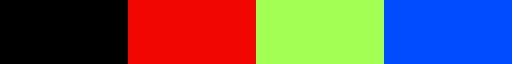

In [86]:
# create a colormap object
ListedColormap(colors=color_array)

In [87]:
# for i in range(len(donors)):
#     # Read COL image and follicle mask
#     img_col = imgs_col[i]
#     print(img_col.shape)
    
#     fig, ax = plt.subplots(figsize=(10,10), facecolor='k')
#     ax.imshow(img_col, cmap=mycmap_y, alpha=1) 

#     ax.axis("off")

In [88]:
dfs_pheno = []
for i in range(len(donors)):
    adata_donor = adata[adata.obs.Dataset == donors[i]]
    X = np.array(adata_donor.obsm['spatial'])[:,[1,0]].astype(int)
    df_pheno = pd.DataFrame(adata_donor.obs.cluster)
    mask_grad = masks_grad[i]
    zones = mask_grad[X[:,0], X[:,1]]
    df_pheno['Zone'] = zones
    df_pheno['Donor'] = donors[i]
    dfs_pheno.append(df_pheno)

In [89]:
df_pheno = pd.concat(dfs_pheno)

In [90]:
df_count = df_pheno.groupby(['Donor', 'Zone'])[['cluster']].value_counts()
df_count = df_count.reset_index()
df_count.columns = ['Donor', 'Zone', 'cluster', 'Count']
df_count = df_count[df_count.Zone != 0]

In [91]:
df_count

Donor  Zone                  cluster  Count
14   INT Donor B     1            Stromal cells   1035
15   INT Donor B     1                     FDCs    643
16   INT Donor B     1               LZ B-cells    362
17   INT Donor B     1                  T cells    266
18   INT Donor B     1        Cytotoxic T-cells    180
..           ...   ...                      ...    ...
331   TS Donor E     3       Regulatory T-cells      6
332   TS Donor E     3                     FDCs      4
333   TS Donor E     3        Cytotoxic T-cells      1
334   TS Donor E     3        Exhausted T-cells      0
335   TS Donor E     3  Follicular CD8+ T-cells      0

[252 rows x 4 columns]

In [92]:
df_pivot = df_count.pivot(index=['Zone', 'Donor'], columns='cluster', values='Count') + 1
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)

In [93]:
df_pivot

cluster            B cells  Cytotoxic T-cells  DZ B-cells  Exhausted T-cells  \
Zone Donor                                                                     
1    INT Donor B  0.040070           0.052555    0.010163           0.030778   
     INT Donor E  0.064821           0.043214    0.003229           0.090339   
     LN Donor A   0.101955           0.023045    0.002793           0.001397   
     LN Donor E   0.332530           0.104418    0.008032           0.006827   
     TS Donor A   0.101329           0.033697    0.073802           0.004034   
     TS Donor E   0.052191           0.000891    0.001603           0.000178   
2    INT Donor B  0.040153           0.047215    0.008273           0.038943   
     INT Donor E  0.117330           0.056281    0.005390           0.043636   
     LN Donor A   0.490444           0.015358    0.004096           0.001024   
     LN Donor E   0.777343           0.045640    0.016463           0.001956   
     TS Donor A   0.166495           0.018512    0.070735           0.002743   
     TS Donor E   0.133563           0.001232    0.000986           0.000123   
3    INT Donor B  0.049965           0.040944    0.006477           0.034698   
     INT Donor E  0.074420           0.081070    0.007357           0.054046   
     LN Donor A   0.562145           0.023344    0.004732           0.002839   
     LN Donor E   0.793236           0.034661    0.012113           0.000959   
     TS Donor A   0.168905           0.014599    0.069373           0.002664   
     TS Donor E   0.255204           0.000226    0.008258           0.000113   

cluster               FDCs  Follicular CD8+ T-cells  \
Zone Donor                                            
1    INT Donor B  0.186992                 0.023810   
     INT Donor E  0.019123                 0.028685   
     LN Donor A   0.009078                 0.000698   
     LN Donor E   0.004016                 0.000803   
     TS Donor A   0.006882                 0.035358   
     TS Donor E   0.005344                 0.000178   
2    INT Donor B  0.135795                 0.031275   
     INT Donor E  0.012749                 0.032235   
     LN Donor A   0.034130                 0.002048   
     LN Donor E   0.000978                 0.001141   
     TS Donor A   0.002743                 0.020569   
     TS Donor E   0.004805                 0.000123   
3    INT Donor B  0.095536                 0.042563   
     INT Donor E  0.011885                 0.030560   
     LN Donor A   0.037539                 0.006309   
     LN Donor E   0.000360                 0.001079   
     TS Donor A   0.001385                 0.021206   
     TS Donor E   0.000566                 0.000113   

cluster           Follicular Helper T-cells  GC B-cells  Helper T-cells  \
Zone Donor                                                                
1    INT Donor B                   0.027294    0.011614        0.051974   
     INT Donor E                   0.062213    0.018813        0.035701   
     LN Donor A                    0.000698    0.018855        0.016760   
     LN Donor E                    0.000402    0.006024        0.011647   
     TS Donor A                    0.004034    0.022544        0.102041   
     TS Donor E                    0.000891    0.092804        0.099572   
2    INT Donor B                   0.039750    0.009483        0.069814   
     INT Donor E                   0.034308    0.019175        0.056074   
     LN Donor A                    0.000341    0.022526        0.022526   
     LN Donor E                    0.000163    0.034067        0.021516   
     TS Donor A                    0.006056    0.025711        0.162381   
     TS Donor E                    0.000739    0.072203        0.350542   
3    INT Donor B                   0.045108    0.008790        0.091603   
     INT Donor E                   0.034097    0.020515        0.066638   
     LN Donor A                    0.000631    0.030915        0.028707   
     LN Donor E        

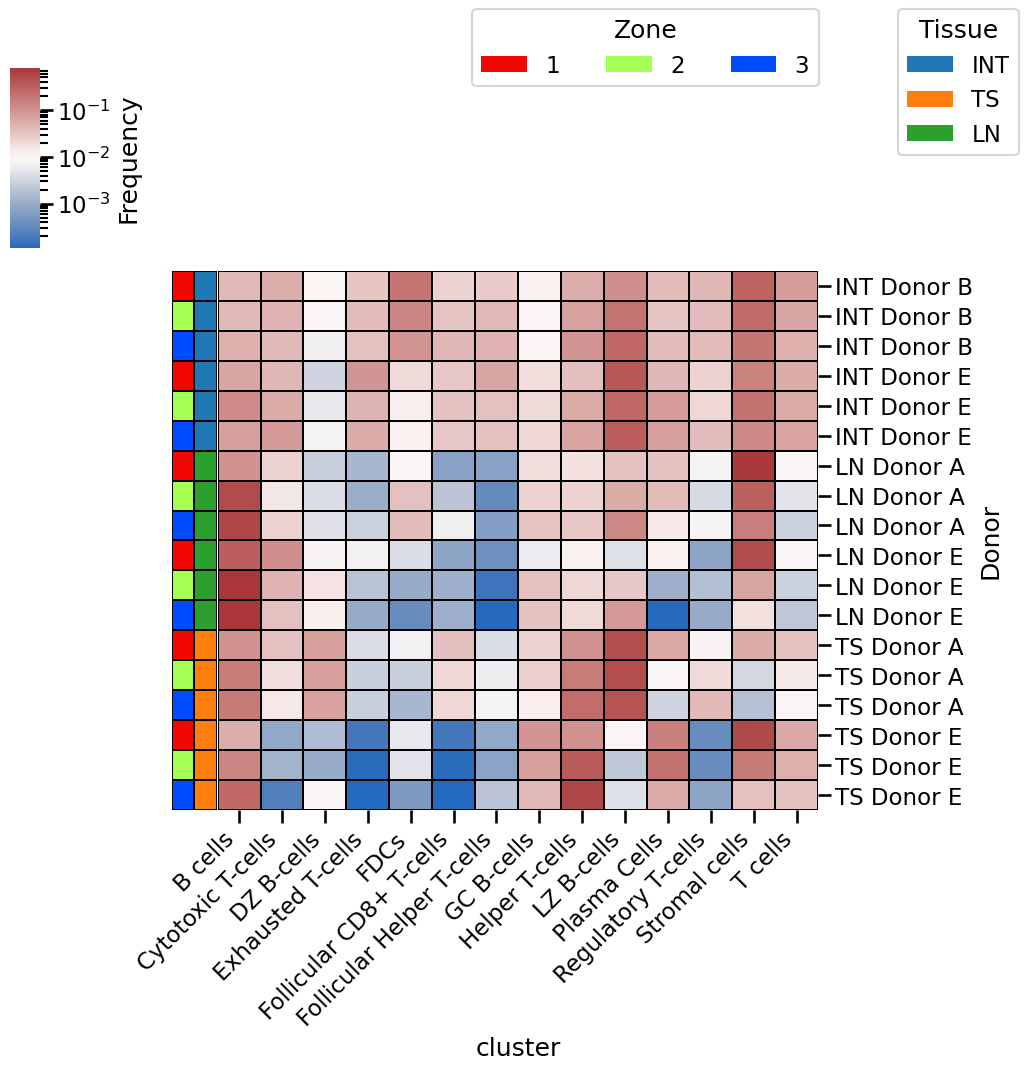

In [110]:
df = df_pivot.sort_index(level=1)

with sns.plotting_context('talk', font_scale=1):
    # Row colors 1
    labels = df.index.get_level_values(0).tolist()
    lut = dict(zip(set(labels), color_array[1:]))
    row_colors = pd.DataFrame(labels, columns=[' '])[' '].map(lut)
    
    # Row colors2
    labels2 = df.index.get_level_values(1).tolist()
    labels2 = [w.split(' ')[0] for w in labels2]
    lut2 = dict(zip(['INT', 'TS', 'LN'], sns.color_palette("tab10")[:len(set(labels2))]))
    row_colors2 = pd.DataFrame(labels2, columns=[' '])[' '].map(lut2)
    
    # Clustermap
    kws = dict(cbar_kws=dict(label='Frequency'))

    g = sns.clustermap(df.droplevel(0, axis=0), cmap="vlag", row_cluster=False, col_cluster=False, linewidth=0.01, dendrogram_ratio=0.15,
                            cbar_pos=(-0.02, 0.9, 0.03, 0.18), row_colors=[row_colors, row_colors2], linecolor='k', norm=LogNorm(),
                           **kws)
    
    # Legend row colors 1
    handles = [Patch(facecolor=lut[name]) for name in lut.keys()]
    l1 = plt.legend(handles, lut, title='Zone', ncol=5,
               bbox_to_anchor=(0.8, 1.15), bbox_transform=plt.gcf().transFigure, loc='upper right')
    
    # Legend row colors 2
    handles2 = [Patch(facecolor=lut2[name]) for name in lut2.keys()]
    l2 = plt.legend(handles2, lut2, title='Tissue',
               bbox_to_anchor=(1.0, 1.15), bbox_transform=plt.gcf().transFigure, loc='upper right')
    plt.gca().add_artist(l1)
    
#     x0, _y0, _w, _h = g.cbar_pos
#     g.ax_cbar.set_position([x0, 0.9, g.ax_row_dendrogram.get_position().width, 0.02])
#     g.ax_cbar.set_title('colorbar title')
#     g.ax_cbar.tick_params(axis='x', length=10)
    
    # Rotation x axis
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Comparison of zonation with only 1 donor

In [56]:
donors

['LN Donor A',
 'LN Donor E',
 'INT Donor B',
 'INT Donor E',
 'TS Donor A',
 'TS Donor E']

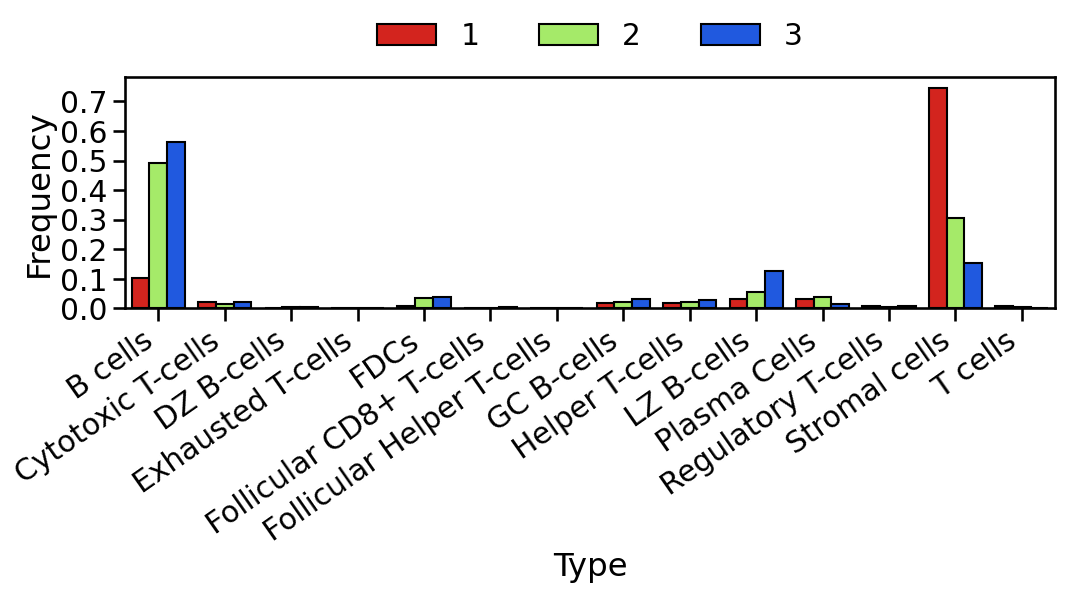

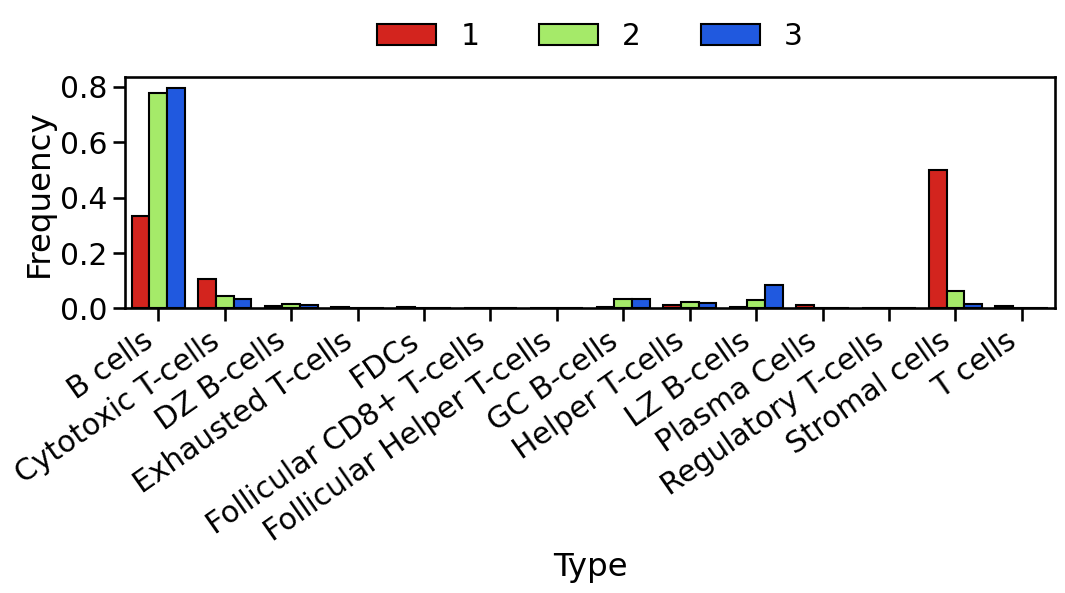

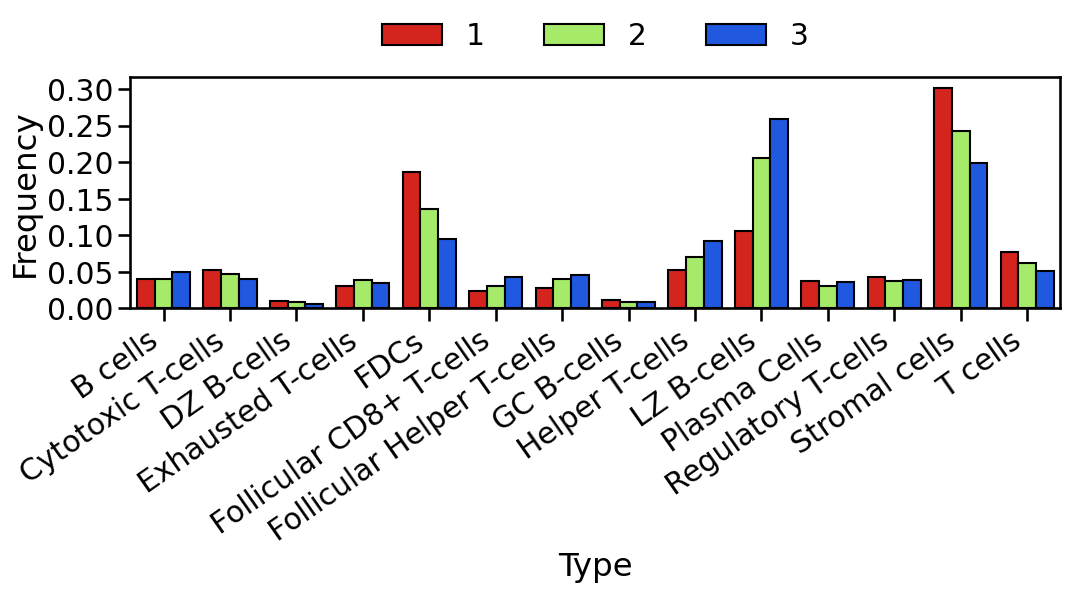

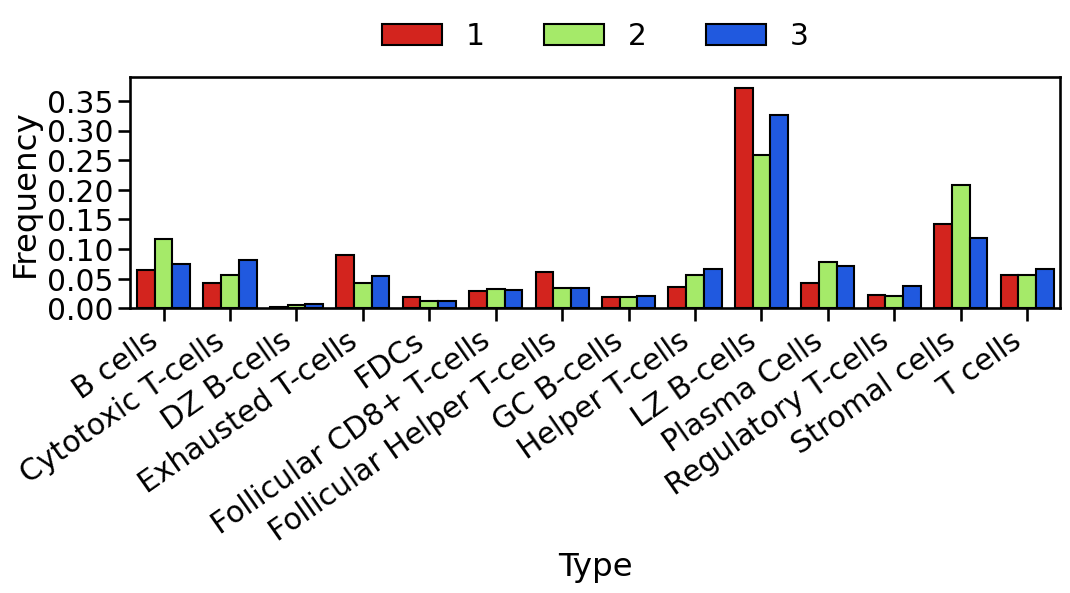

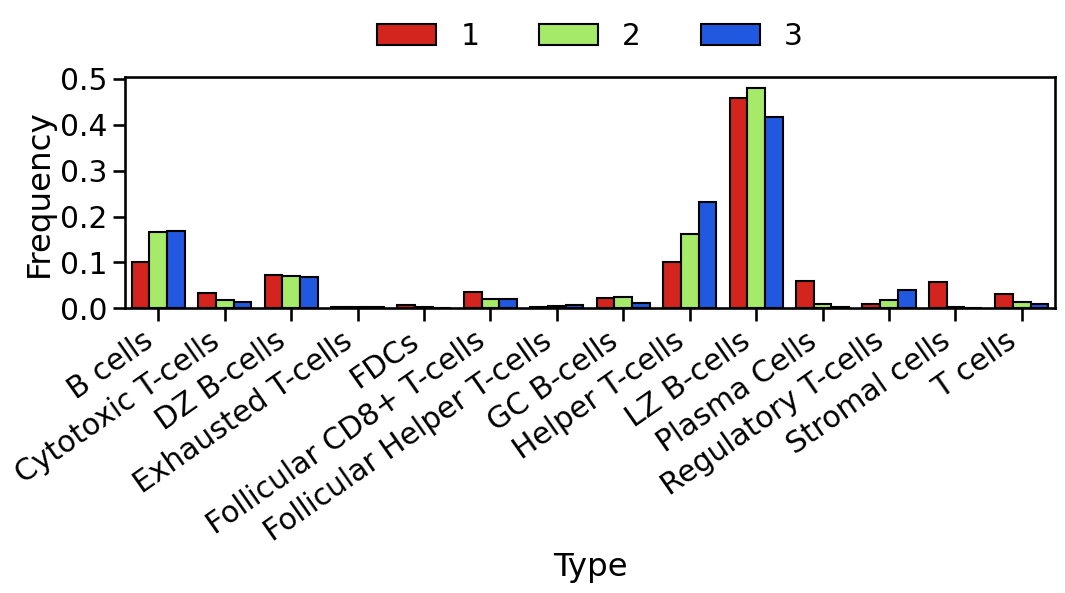

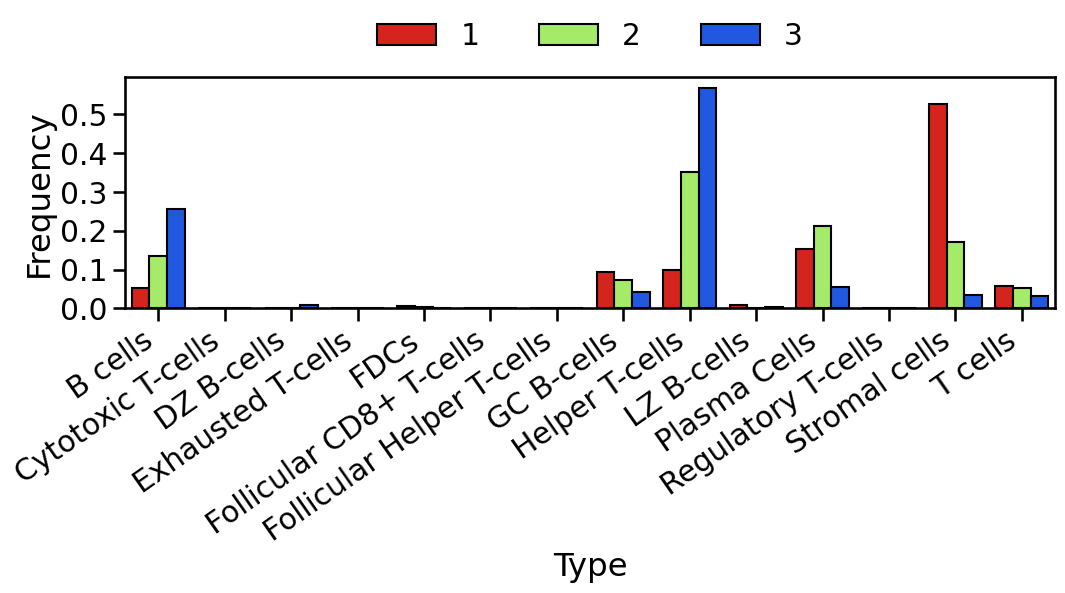

In [57]:
# Only one dataset
markers = ['B-cells', 'DZ B-cells','FDC', 'Helper T-cells', 'LZ B-cells', 'Stroma', 'TFH']

for donor in donors:
    df_subset = df_pivot.loc[df_pivot.index.get_level_values(1) == donor, :]
    
#     df = df_subset
#     with sns.plotting_context('talk', font_scale=1.5):
#         # Row colors 1
#         labels = df.index.get_level_values(0).tolist()
#         lut = dict(zip(set(labels), color_array[1:]))
#         row_colors = pd.DataFrame(labels, columns=[' '])[' '].map(lut)

#         # Clustermap
#         kws = dict(cbar_kws=dict(label='Frequency'))

#         g = sns.clustermap(df.droplevel(1, axis=0), cmap="vlag", row_cluster=False, col_cluster=False, linewidth=0.01, dendrogram_ratio=0.15,
#                                 cbar_pos=(-0.02, 0.9, 0.03, 0.18), row_colors=[row_colors], linecolor='k', norm=LogNorm(), figsize=(14,8),
#                                **kws)
#         # Rotation x axis
#         plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
#         plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, ha='left')
        
    # Barplot
    df_subset = (df_subset.reset_index()
     .melt(id_vars=['Donor', 'Zone'], var_name=['Type'], value_name='Frequency')
    )

    with sns.plotting_context('talk', font_scale=1.3):
        fig,ax = plt.subplots(figsize=(12,3))
        sns.barplot(data=df_subset, x="Type", y="Frequency", hue="Zone", ax=ax, palette=color_array[1:],
                   edgecolor='k')
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
        plt.xticks(rotation=35, ha='right')

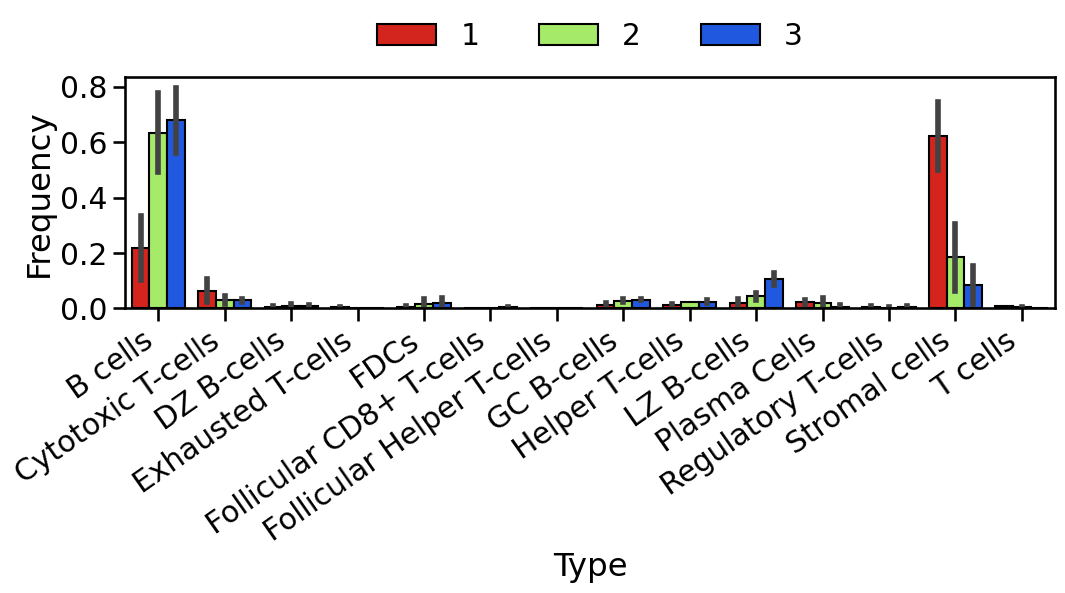

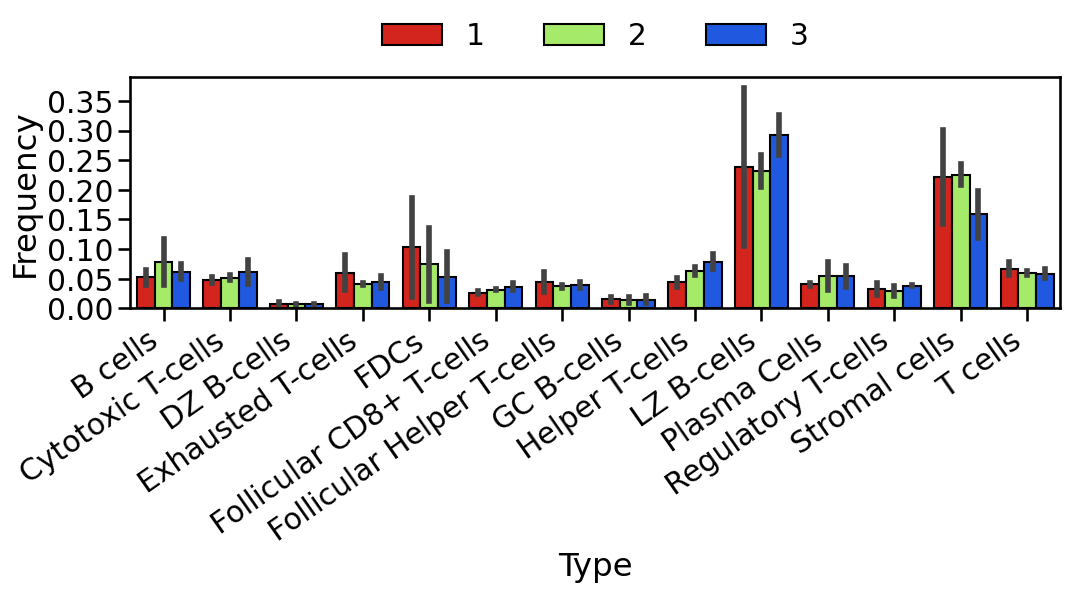

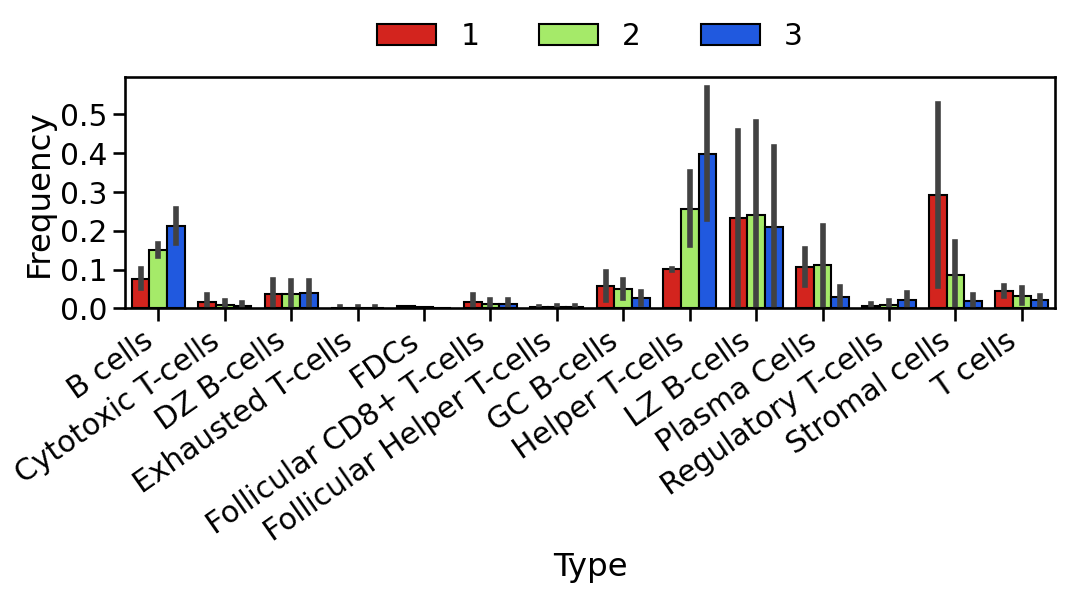

In [58]:
tissues = [['LN Donor A',
 'LN Donor E'],
 ['INT Donor B',
 'INT Donor E'],
 ['TS Donor A',
 'TS Donor E']]

for tissue in tissues:
    df_subset = df_pivot.loc[df_pivot.index.get_level_values(1).isin(tissue), :]
    
    # Barplot
    df_subset = (df_subset.reset_index()
     .melt(id_vars=['Donor', 'Zone'], var_name=['Type'], value_name='Frequency')
    )

    with sns.plotting_context('talk', font_scale=1.3):
        fig,ax = plt.subplots(figsize=(12,3))
        sns.barplot(data=df_subset, x="Type", y="Frequency", hue="Zone", ax=ax, palette=color_array[1:],
                   edgecolor='k')
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
        plt.xticks(rotation=35, ha='right')

In [59]:
# df = df_pivot.loc[df_pivot.index.get_level_values(1) == donor, markers]

# with sns.plotting_context('talk', font_scale=1.5):
#     # Row colors 1
#     labels = df.index.get_level_values(0).tolist()
#     lut = dict(zip(set(labels), color_array[1:]))
#     row_colors = pd.DataFrame(labels, columns=[' '])[' '].map(lut)

    
#     # Clustermap
#     kws = dict(cbar_kws=dict(label='Frequency'))

#     g = sns.clustermap(df.droplevel(1, axis=0), cmap="vlag", row_cluster=False, col_cluster=False, linewidth=0.01, dendrogram_ratio=0.15,
#                             cbar_pos=(-0.02, 0.9, 0.03, 0.18), row_colors=[row_colors], linecolor='k', norm=LogNorm(), figsize=(14,8),
#                            **kws)
    

#     # Rotation x axis
#     plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha='right')
#     plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, ha='left')

In [60]:
# df_subset = (df.reset_index()
#  .melt(id_vars=['Donor', 'Zone'], var_name=['Type'], value_name='Frequency')
# )

# with sns.plotting_context('talk', font_scale=1.3):
#     fig,ax = plt.subplots(figsize=(12,3))
#     sns.barplot(data=df_subset, x="Type", y="Frequency", hue="Zone", ax=ax, palette=color_array[1:],
#                edgecolor='k', width=0.9)
#     sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
#     plt.xticks(rotation=35, ha='right')

# Plot clustered cell in mask

In [61]:
# Plot clustered cell within each mask
import matplotlib 
from PIL import Image
from skimage import measure 

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


In [62]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [63]:
adata.obs.columns = ['Donor', 'Phenotype', 'ROI', 'Cell', 'index', 'Dataset', 'cluster'] 

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
3
2
1


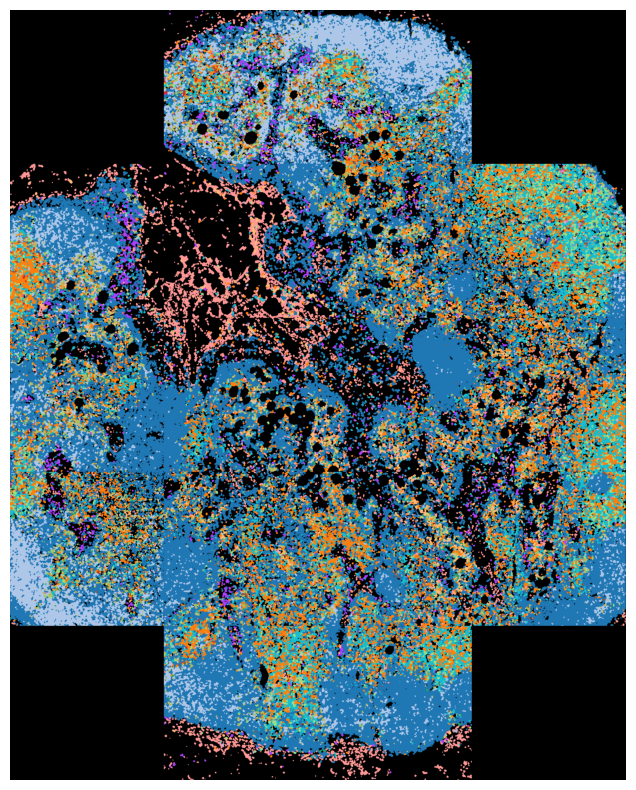

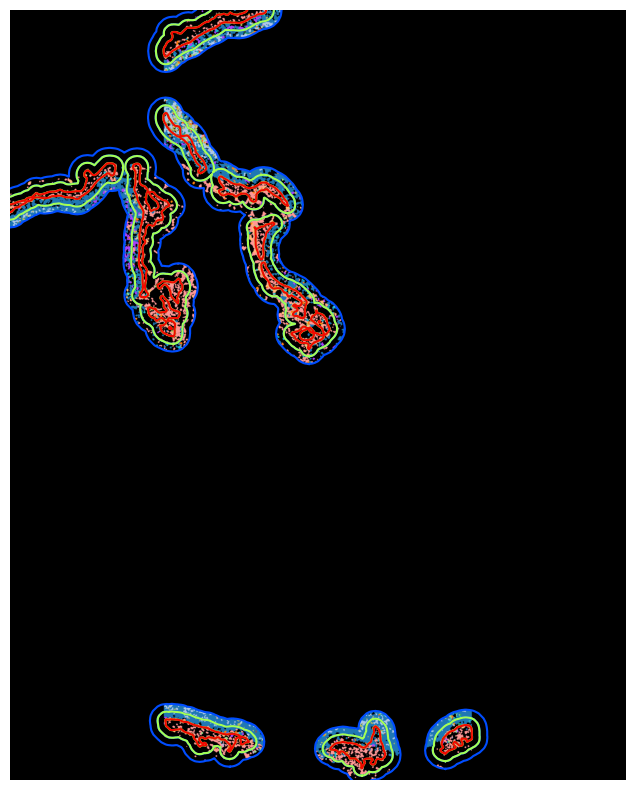

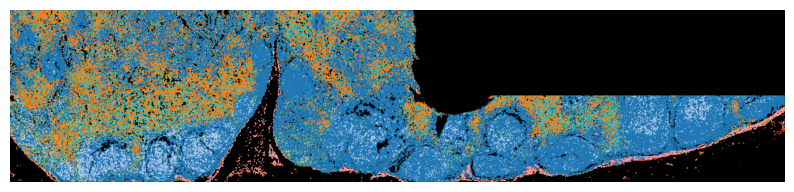

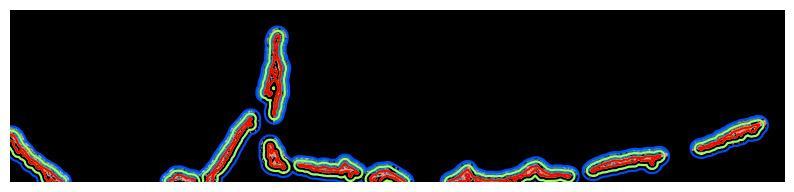

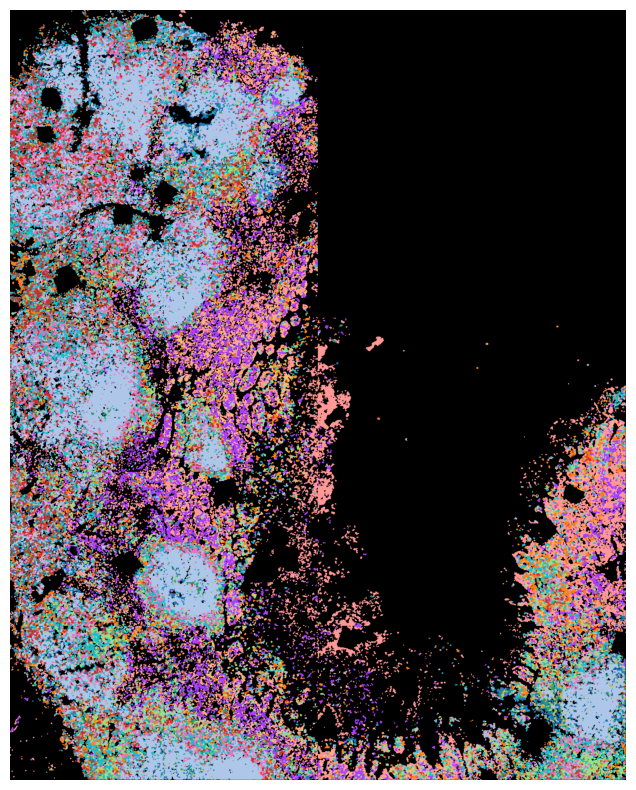

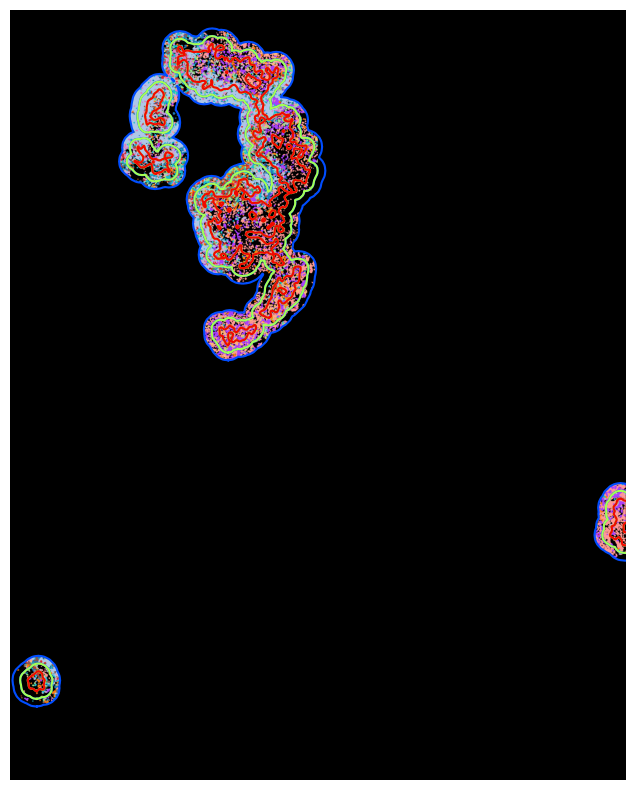

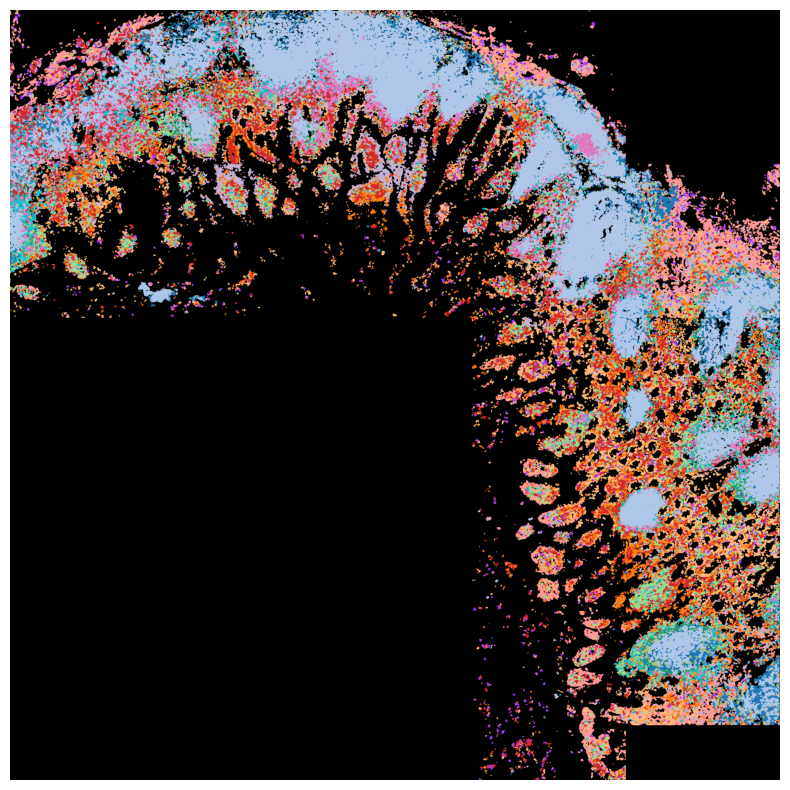

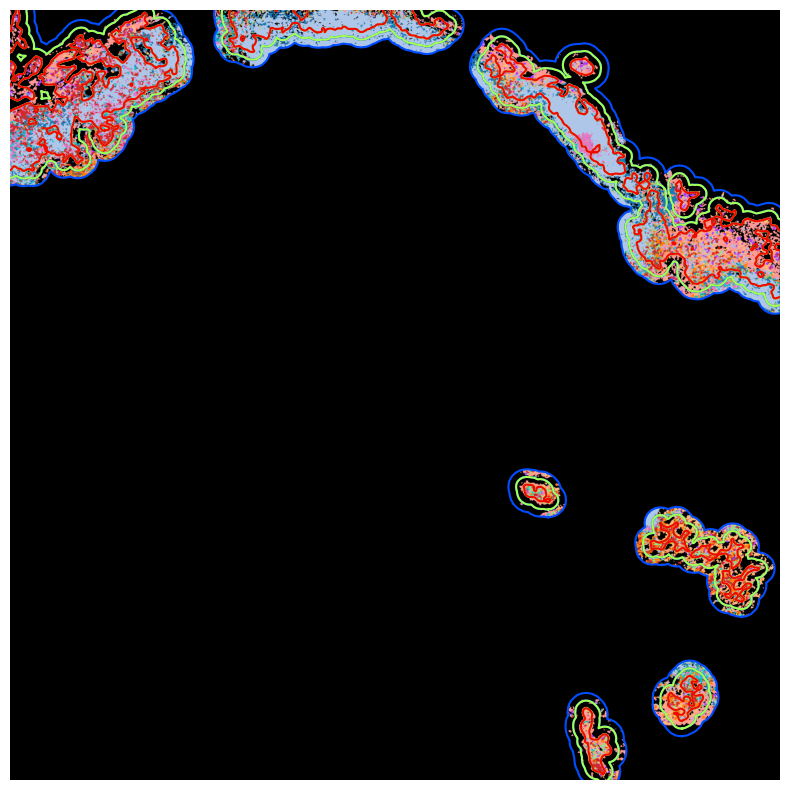

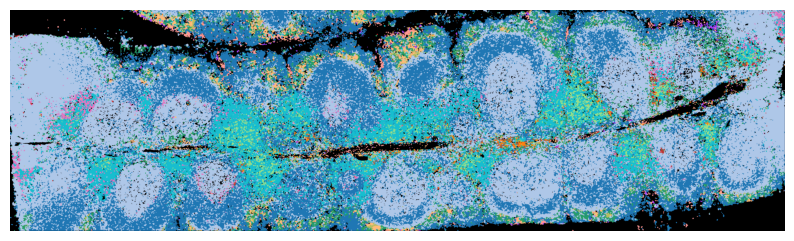

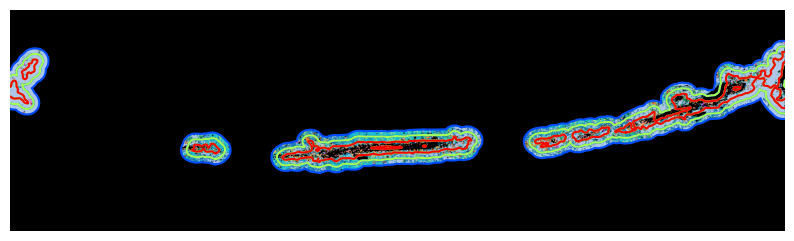

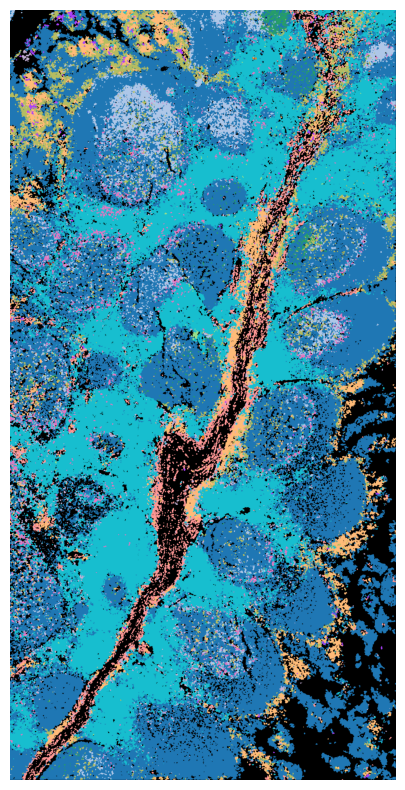

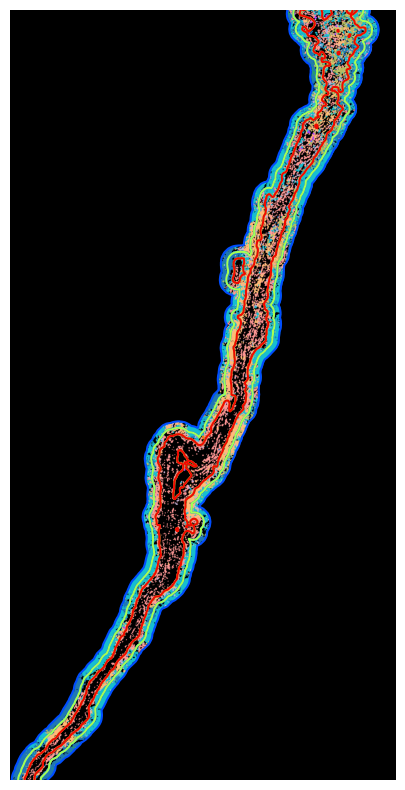

In [64]:
for donor in donors:
# Get mask
    masks = get_masks(data_dir / "masks" / donor)

    # Get adata 
    phenotype_name = 'cluster'

    sc.tl.dendrogram(adata, groupby=phenotype_name)

    adata.uns["New_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata.obs[phenotype_name]))]
    cluster_label_order = adata.uns[f'dendrogram_{phenotype_name}']['categories_ordered']

    # Define colormap
    colors = adata.uns["New_colors"]
    labels = adata.obs[phenotype_name].cat.categories.tolist()

    colors_rgb = []
    for color in colors:
        colors_rgb.append(matplotlib.colors.hex2color(color))
    colors_rgb = np.array(colors_rgb) * 255
    colors_rgb = colors_rgb.astype(np.uint8)
    colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}
    
    size = 1000 
    adata_donor = adata[adata.obs.Dataset == donor, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    mask_grad = masks_grad[donors.index(donor)]

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img
        
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img_combined)
    ax.axis('off')
    
    mask_temp = mask_grad > 0
    mask_temp = np.broadcast_to(mask_temp[..., np.newaxis], img_combined.shape)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(np.where(mask_temp>0, img_combined,0))
    ax.axis('off')

    for zone in np.unique(mask_grad)[::-1][:-1]:
        print(zone)
        # Get zone mask
        mask_temp = mask_grad == zone

        # Get follicle contours
        contours = measure.find_contours(mask_temp, 0.8)
        # contours, hierarchy = cv2.findContours(mask_temp.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # Pot contours
        for j, contour in enumerate(contours):
            contour = contour.squeeze()
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color=color_array[zone], linestyle='-')


In [65]:
donor = donors[-1]

# Get mask
masks = get_masks(data_dir / "masks" / donor)

# Get adata 
phenotype_name = 'cluster'

sc.tl.dendrogram(adata, groupby=phenotype_name)

adata.uns["New_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata.obs[phenotype_name]))]
cluster_label_order = adata.uns[f'dendrogram_{phenotype_name}']['categories_ordered']

# Define colormap
colors = adata.uns["New_colors"]
labels = adata.obs[phenotype_name].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)
colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`


In [66]:
# c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# # legend
# fig, ax = plt.subplots(figsize=(1,15))
# ax.barh(y=range(len(colors_rgb_dict.values())), 
#         color=c/255,
#         width=1, 
#         height=1,
#         edgecolor='k',
#         linewidth=3,
#        )
# _ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
# _ = plt.xticks([])
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.tick_params(axis=u'both', which=u'both',length=0)
# # ax.yaxis.tick_right()
# ax.invert_yaxis()
# ax.grid(False)


In [67]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [68]:
size = 1000 
adata_donor = adata[adata.obs.Dataset == donor, :]

# Create combined images
y_max, x_max = get_img_size(arrangement[donor])
img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

mask_grad = masks_grad[donors.index(donor)]

for i in adata_donor.obs.ROI.unique():
    if i not in arrangement[donor].keys():
        continue

    # Get dataset
    adata_s = adata_donor[adata_donor.obs.ROI == i, :]
    mask = masks[str(int(i))]

    # Get label2cell dict
    label2cell = {}
    for j, l in enumerate(labels):
        cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
        label2cell[j] = cell_id

    img = create_clustered_cell(mask, label2cell, colors_rgb)

    # Insert to combine image
    y = max(0, arrangement[donor][i][0] - 1)
    x = max(0, arrangement[donor][i][1] - 1)
    img_combined[y : y + size, x : x + size] = img

(-0.5, 2999.5, 5999.5, -0.5)

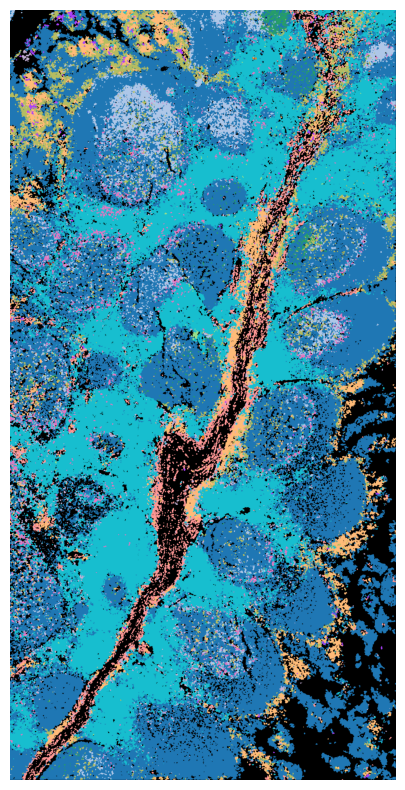

In [69]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_combined)
ax.axis('off')

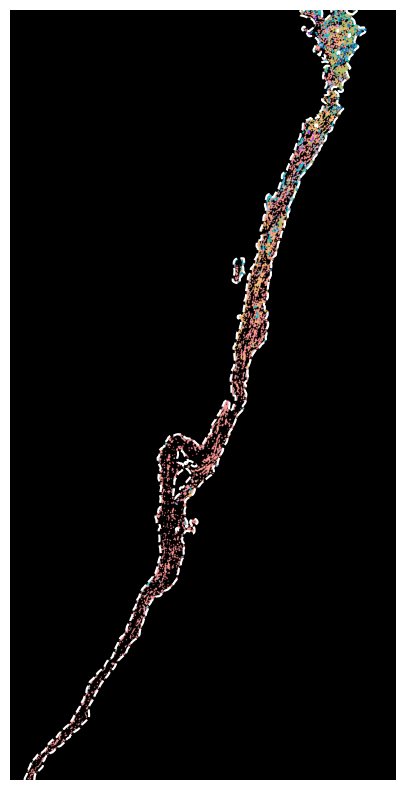

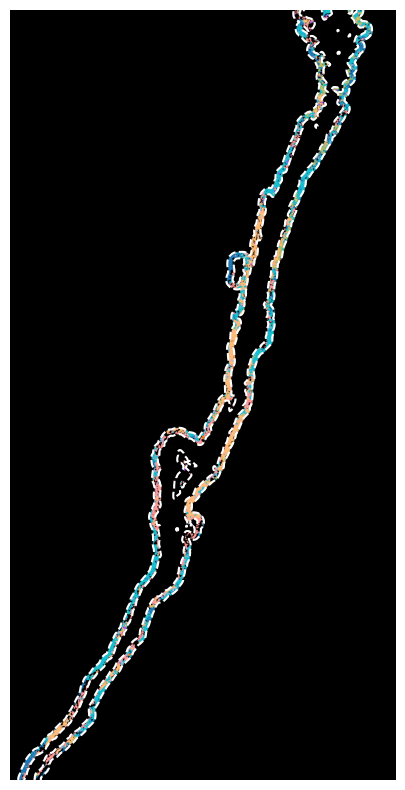

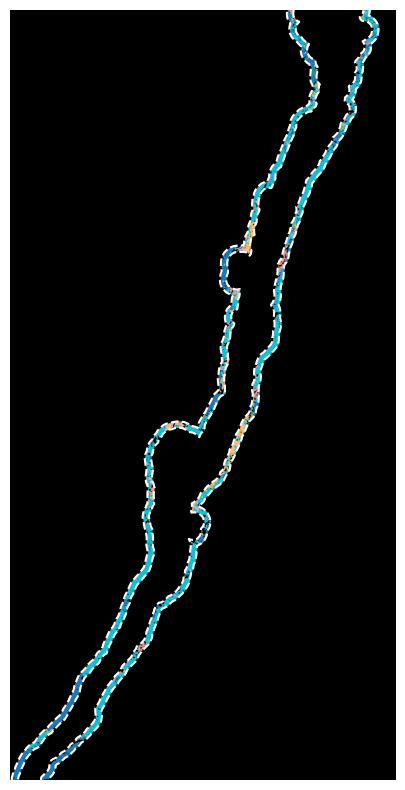

In [70]:
for zone in np.unique(mask_grad)[1:]:
    # Get zone mask
    mask_temp = mask_grad == zone
    
    # Get follicle contours
    contours = measure.find_contours(mask_temp, 0.8)
    
    # Plot images
    mask_temp = np.broadcast_to(mask_temp[..., np.newaxis], img_combined.shape)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(np.where(mask_temp>0, img_combined,0))
    ax.axis('off')
    for j, contour in enumerate(contours):
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color="white", linestyle='dashed')

3
2
1


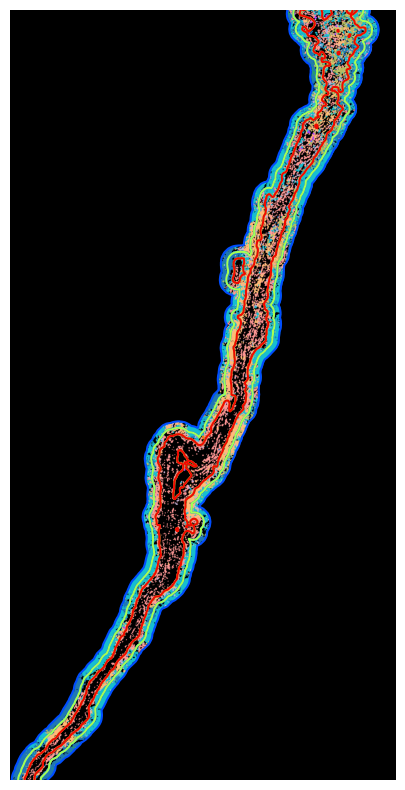

In [71]:
mask_temp = mask_grad > 0
mask_temp = np.broadcast_to(mask_temp[..., np.newaxis], img_combined.shape)
    
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(np.where(mask_temp>0, img_combined,0))
ax.axis('off')

for zone in np.unique(mask_grad)[::-1][:-1]:
    print(zone)
    # Get zone mask
    mask_temp = mask_grad == zone
    
    # Get follicle contours
    contours = measure.find_contours(mask_temp, 0.8)
    # contours, hierarchy = cv2.findContours(mask_temp.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Pot contours
    for j, contour in enumerate(contours):
        contour = contour.squeeze()
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color=color_array[zone], linestyle='-')
